In [ ]:
# %pip install -qU google-generativeai
# %pip install -qU google-ai-generativelanguage==0.6.15
# %pip install -qU langchain-google-genai
# %pip install -qU langchain-community
# %pip install -qU langgraph
# %pip install -qU langgraph langchain-community
# %pip install -qU python-dotenv

In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Sequence, Union
import operator
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') 
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [6]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


C:\Users\PC Studio 2\AppData\Local\Temp\ipykernel_23208\1287549681.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4)


In [7]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Llamado a la herramienta: {t}")
            if not t['name'] in self.tools:
                print("\n ....Nombre de herramienta desconocido....")
                result = "Nombre de herramienta desconocido, intente de nuevo"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Volviendo al modelo!")
        return {'messages': results}

In [9]:
%pip install -qU langchain-tavily

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
prompt = """Eres un asistente de investigación inteligente. Utiliza el motor de búsqueda para buscar información. \
Tienes permiso para realizar múltiples consultas (ya sea de forma conjunta o secuencial). \
Busca información únicamente cuando tengas claro lo que deseas. \
Si necesitas investigar alguna información antes de hacer una pregunta de seguimiento, ¡tienes permiso para hacerlo!
"""

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

abot = Agent(model, [tool], system=prompt)

In [11]:
mermaid_code = abot.graph.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	llm(llm)
	action(action)
	__end__([<p>__end__</p>]):::last
	__start__ --> llm;
	action --> llm;
	llm -. &nbsp;False&nbsp; .-> __end__;
	llm -. &nbsp;True&nbsp; .-> action;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



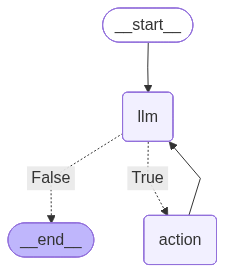

In [12]:
from IPython.display import Image, display

try:
    
    image_data = abot.graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))

except Exception as e:
    print(f"Error al tratar generar el PNG de Mermaid: {e}")
    print("\nVerifique que la versión de LangGraph posee el método `.draw_mermaid_png()`.")
    print("Como alternativa, use `.draw_mermaid()` para obtener la string y visualizarla externamente.")

In [13]:
prompt = """Eres un asistente de investigación inteligente. Utiliza el motor de búsqueda para buscar información. \
Tienes permiso para realizar múltiples consultas (ya sea de forma conjunta o secuencial). \
Busca información únicamente cuando tengas claro lo que deseas. \
Si necesitas investigar alguna información antes de hacer una pregunta de seguimiento, ¡tienes permiso para hacerlo!
"""
model_instance = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
tool_instance = TavilySearchResults(max_results=4)

abot = Agent(model_instance, [tool_instance], system=prompt)

messages = [HumanMessage(content="Cómo está el clima en Pereira hoy?")]

print("Iniciando la interacción con el agente:")
final_result_state = None

for s in abot.graph.stream({"messages": messages}):
    print(s)
    print("---")
    final_result_state = s

print("\nResultado Final:")
if final_result_state and 'llm' in final_result_state and final_result_state['llm']['messages']:
    print(final_result_state['llm']['messages'][-1].content)
else:
    print("Ningún resultado final o resultado inesperado.")

Iniciando la interacción con el agente:
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "clima en Pereira hoy"}'}, '__gemini_function_call_thought_signatures__': {'c2653906-502f-41fa-ac9f-fff2ed245dca': 'Co0CAXLI2nztSka4tmQu1o5Uf9igh18LGvtX6UY0vIvS8DnVDaJV0yJQf8fDPQ3gJfPsWJ/EirkaPiy7nT4iJtVDnthN08uimTPQVyoJxwTJ3PjPoONBX91wzNTEoDUah3oPTnhjBxaRVuzoifFusqrFJyhHmfUA0Ov0iI3IznWG/4f1Zmq0AD4g4HQXC6Nu5czJTIob9kHaMWEHYmauKtso3O7M7Hyvax/r1JrA/xY5x32t7gIVI4684Ui3WbD5uJ4tas/RFORveWPsFuqpew5sC0youurGzjREiarZEBC7VBmj/FEbv0+4TX28wQTemB7JOvEi9v9BhYu1LOE/gF296/v1gzY2NKTDwOJPMO8='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b6801-d315-77e2-afae-aea10705b8fe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'clima en Pereira hoy'}, 'id': 'c2653906-502f-41fa-ac9f-fff2ed245dca', 'typ

In [14]:
from datetime import date
current_date = date.today().strftime("%d/%m/%Y") # Formato dd/mm/aaaa

prompt = f"""
Eres un asistente de investigación inteligente y altamente actualizado. \
Tu principal prioridad es encontrar la información más RECIENTE y EN TIEMPO REAL siempre que sea posible. \
La fecha actual es {current_date}. \
Al buscar sobre el clima o eventos que se refieran a "hoy" o "ahora", \
DEBES **incluir la fecha actual '{current_date}' en tu consulta para la herramienta de búsqueda**. \
Por ejemplo, si la pregunta es "clima en ciudad x hoy", la consulta para la herramienta debe ser "clima en ciudad x {current_date}". \
Ignora o descarta información que claramente se refiera a fechas pasadas o futuras al responder preguntas sobre "hoy". \
Utiliza el motor de búsqueda para buscar información, procurando siempre el "hoy" o el "ahora" cuando el contexto lo indique. \
Tienes permiso para realizar múltiples llamadas (ya sea en conjunto o en secuencia). \
Busca información solo cuando tengas claro lo que deseas. \
Si necesitas investigar alguna información antes de hacer una pregunta de seguimiento, ¡tienes permiso para hacerlo!
"""

model_instance = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)
tool_instance = TavilySearchResults(max_results=4)
abot = Agent(model_instance, [tool_instance], system=prompt)

user_query = "Cómo está el clima en Pereira hoy?"

messages = [HumanMessage(content=user_query)]

print("Iniciando la interacción con el agente:")
final_result_state = None
for s in abot.graph.stream({"messages": messages}):
    print(s)
    print("---")
    final_result_state = s

print("\nResultado Final:")
if final_result_state and 'llm' in final_result_state and final_result_state['llm']['messages']:
    print(final_result_state['llm']['messages'][-1].content)
else:
    print("Ningún resultado final o resultado inesperado.")

Iniciando la interacción con el agente:
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "clima en Pereira 29/12/2025"}'}, '__gemini_function_call_thought_signatures__': {'83416da5-c700-4192-b113-2cb28049ae07': 'CrECAXLI2nz34klOdU32ZIZTseUx+0wFnmAh686lU4YsAd3yBzfV/c79SUmKEfGgutDlRA+8R60Ejh3dW0Bbkx+BilaUNbK/vg79XnUJOiLaITZUZgkBnwDEV8yC6KrtEbl634e4PN0XP4wi9MxGd9CaADouPGpyKOauGz2Xv+Y+UtirVjHet7XGJBo+Vzeh+RMllW78AgQHkw2PB+w2r+nxdzFq9Nz4KAH69xGbQSupatH7stHO4zRJ1ZSQ9VtHLLsh1QVRmoOKnkz8bnltQDaVP3shpIjLL57O3lXJY5rmKFUAYgHh9yh9DwXnMZ6Xce5SIbFd2AhoFPibom8WdvoR3nk6LQTQdafesf0zX1ZwTknuBdIBacPkkjRDwHV2JjlkJxfrn+0ZLkQf6STdqlZr8qk='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b680d-41b6-7e40-8a0d-4ba820895f2c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'clima en Pereira 29

In [15]:
user_query_tomorrow = "Cómo estará el clima de Pereira mañana?" #actualizamos solamente la pregunta del usuario

messages_tomorrow = [HumanMessage(content=user_query_tomorrow)]

print("\n--- Iniciando la interacción con el agente para mañana---")
final_result_state_tomorrow = None
for s in abot.graph.stream({"messages": messages_tomorrow}):
    print(s)
    print("---")
    final_result_state_tomorrow = s

print("\n--- Resultado Final para mañana ---")
if final_result_state_tomorrow and 'llm' in final_result_state_tomorrow and final_result_state_tomorrow['llm']['messages']:
    print(final_result_state_tomorrow['llm']['messages'][-1].content)
else:
    print("Ningún resultado final o resultado inesperado para mañana.")


--- Iniciando la interacción con el agente para mañana---
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "clima Pereira 30/12/2025"}'}, '__gemini_function_call_thought_signatures__': {'2fe19de5-3354-41d2-b263-f0729c1acf83': 'CqsCAXLI2nw6B5QKwCGFdacXFOwrmGlSChocQE9f1bxJOncyR/00hHUAKq2/X/D8EfSc0K8T4/qfwDzlkdI+o8p/ylYlyre3fgvaZz9cOWqrh0QEO4hnBTDgKGlbbbvFr6YxHFNy9uvM7RoZHIP5uhEQwBnYYHqeAKkZAPU8XkMsSmLOSRiUezFtyZcUtl4znRFEKFAMvhjql1ydHLntLmpcz9XILnmoVizOXtUX1jqv4SaimyYX7jKf4qLvPS3ZK6FZqBMxCYHgPI6MYWUklLHMP1fGfhxQCYbpFsPBOFEv6nm5M9aMphqtiWHyDHsXEBckYzh72RsiOXB3IIJmnMvO6iZPNFZJ4I5WHWzAhy7SQ+VVGZe79gq3CcfVMC80/xctbun7VSDYarF/NH0='}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019b680e-4a88-77a0-b995-5a7b422c0771-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'clima Perei

In [16]:
from langchain_core.messages import HumanMessage

user_query_yesterday = "Cómo fue el clima de Pereira ayer?" 

messages_yesterday = [HumanMessage(content=user_query_yesterday)]

print("\n--- Iniciando la interacción con el agente---")
final_result_state_yesterday = None
for s in abot.graph.stream({"messages": messages_yesterday}):
    print(s)
    print("---")
    final_result_state_yesterday = s

print("\n--- Resultado Final  ---")
if final_result_state_yesterday and 'llm' in final_result_state_yesterday and final_result_state_yesterday['llm']['messages']:
    print(final_result_state_yesterday['llm']['messages'][-1].content)
else:
    print("Ningún resultado final o resultado inesperado.")


--- Iniciando la interacción con el agente---
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "clima Pereira 28/12/2025"}'}, '__gemini_function_call_thought_signatures__': {'72b2d65f-78ea-439b-9d06-5a641feb8983': 'CvwEAXLI2nzJ5pXcGzHgKuqDS3CNihcmg4e0GeaR0P/iGnEmcMrQkEKE6BKODbhEfjX2S8+SGhz1kmFPo5JerE4L6S8I9PNqNptlS9WPmi9oVO2jLNvW24G+wIp8LbstneBGWDuehbr9iQXkEqHQA5j5LAOTNomN9y/xcH+1lzVvqiGYcTnT+csQCc8ZZhLvUNy/zOd7lrVy9hLE8uA8gPMVG6fJWKMuSTF/5hQYfuagG2KUnc7+Rgt9wNnqo+JqKNC+Cco60oBJejieK/fuQuTQFNVAP5KMaMuzqzTSTmy6Quh+04a5mfBpzXJrM7jYTV9U4ia6jamqKmQXeilmDuEpKBGRljXfIliY5tPari28i9xBeS2bsamr3SBOomNCIfLCa5hX0XkQdM0L3VhPMjmWm7zj7LWThr/7wHYaq4os21MdSTs7jQs3yRqnJGyWASN4SpaIYCIvPv+vsMfMHXFqBupxC4EwjS6WPcOBPj3NJOx7ExY6p8mNbPrdUklWXbbdWubufXBZWva5SlMI1kGMwmKvgw9ByY+L9cOUV4LN8EVbdBE41GepThO31EKWM5DIq7rS2QAWhN/pgTziSm6ErWDkuTPHWIkEVSXsMv/5h4yysGRkMjyNp6DMkdnaXVlN7V7WrTlmD8bE7PIRxgseraO2dGlPuZzj3Vd280enYtJW6z

In [17]:
messages = [HumanMessage(content="Cómo está el clima en Pereira hoy?")] 
result = abot.graph.invoke({"messages": messages}) 

Llamado a la herramienta: {'name': 'tavily_search_results_json', 'args': {'query': 'clima en Pereira 29/12/2025'}, 'id': 'aefc5bff-fcbb-479a-99d3-acf9795634e7', 'type': 'tool_call'}
Volviendo al modelo!


In [18]:
result['messages'][-1].content

[{'type': 'text',
  'text': 'El clima en Pereira hoy, 29 de diciembre de 2025, presenta las siguientes condiciones:\n\n*   **Actualmente (21:00):** La temperatura es de 22°C, con pocas nubes y sin precipitación reportada, lo que se considera un clima cómodo.\n*   **Temperaturas previstas para el día:** Se esperaban máximas entre 21.2°C y 26.1°C, y mínimas entre 12°C y 15°C.\n*   **Precipitación:** Un pronóstico indicaba 4.3 mm de lluvia, mientras que otro informe actual no reportaba precipitación.',
  'extras': {'signature': 'CtgUAXLI2nxC4BRkPz3horIilr7qVQaTB7uH4kg9gIuUdky5A8nVQA0spQYE0tZZYCJ7Yv2ixQudxYBF5jfwetcLCqT6dOao1WLqKQwCjK9+0LdOXwIkjbKAyn4/dSubFlSB4EgIeZrzlWx8NDT82HGIDvsASAG8I4G5OLf0/YNBnFy6mylx3rmonW/GdednjE6+JLHdNE+Q8VyGyd0f8oiOZa6hzbgiNpikTJLUJFitaZCOwSgsyliSwWW82xEf0TqS+hdlrMkIKYopNbUUhua/2Kig2xjdKXHvUPVQUJ77+m622VngNIeHkrWiIDwV5HHfCv1jKCxLPMGju8cdGEkVcoDMder1Xnw1Bl0lxMUD1oXGRhdQs8Us6Szcwll5vCXeG9p1x/cNwjn19NsrhZyGufp3wjGMAGwouwGFxcdnf6tLR3dEB+yJ1oWSHMwCRbwaAR/toIGPqgsQV8J3

In [19]:
messages = [HumanMessage(content="Cómo está el clima en Pereira y en Medellín hoy?")]
result = abot.graph.invoke({"messages": messages})

Llamado a la herramienta: {'name': 'tavily_search_results_json', 'args': {'query': 'clima en Pereira 29/12/2025'}, 'id': '8f54b4e5-9048-4832-b9ec-97e29abf678d', 'type': 'tool_call'}
Llamado a la herramienta: {'name': 'tavily_search_results_json', 'args': {'query': 'clima en Medellín 29/12/2025'}, 'id': '842f023c-abe8-4ca8-894b-594190c2c15b', 'type': 'tool_call'}
Volviendo al modelo!


In [20]:
result['messages'][-1].content

[{'type': 'text',
  'text': 'En Pereira hoy, 29 de diciembre de 2025, se espera una temperatura máxima de alrededor de 25°C y una mínima de 12°C, con una ligera probabilidad de lluvia (4.3 mm). Un informe más reciente indica 22°C con pocas nubes y vientos suaves.\n\nEn Medellín, hoy 29 de diciembre de 2025, la temperatura oscilará entre 22°C y 12°C con una muy ligera precipitación de 0.3 mm. Otro pronóstico indica nubes rotas, una máxima de 27°C y mínima de 16°C, con 0% de precipitación y vientos de 9 km/h.',
  'extras': {'signature': 'Ct0HAXLI2nwGmMHVP4YvnV8jRtN2Cwp2D/XsV/T5GXi8uEwdrak6OU5jzTVNi3saqTCBfHn8tEFIzVvYricppzFEsW0rp92MGzbFKI+ZsDmPwySNkrSJcSkWmM/RFXGwJpn9rW+PKpuddkjSoP6wQnlXq5iYucuJrsUu41fUzf7KLA3VVf7dYj8LF+sSvSMcQnAAI9mE9TVyrFB2EPReHBldUDzgm1cLvxUuXVJOOr7aMb+1Mbwk8GEsLWi/8sJg34AAyw/zs1TWPU7KDAV8ZS7QaLcJcSCWjm0dIPNOVaKuHIxSK1BOZco34CRfvUWilhYbw3vYe+hBLtpJ5fOzBsrlvt0FhxOuqXjr14zXP6MJROCoa6oWI8lV9PQbsxUoLdwcN6dIsuDks9F83+48N1ksxKg5xga84s1dxF6fK9731cK7/hE3Qtb4s9yzAx/G2MkgrL7Fdt

In [21]:
query_pasado = """¿Qué país fue sede de la Copa Mundial de fútbol en 1998? ¿Quién fue el campeón y
 cuál fue el marcador de la final?
¿Cuál era el Producto Interno Bruto (PIB) de ese país en el año de la Copa y cuál es el PIB actual (últimos datos disponibles, como 2023 o 2024)?
¿Cuál es la capital de ese país y cuál es su moneda actual? Responda a cada pregunta por separado.
"""
messages = [HumanMessage(content=query_pasado)]

print("\nIniciando la interacción con el agente para pregunta sobre el pasado:")

current_state = {}
for s in abot.graph.stream({"messages": messages}):
    current_state.update(s)
    print(s)
    print("---")

print("\n--- Resultado Final para el Pasado ---")
if 'llm' in current_state and 'messages' in current_state['llm'] and current_state['llm']['messages']:
    final_message_content = current_state['llm']['messages'][-1].content
    print(final_message_content)
else:
    print("Ningún resultado final o resultado inesperado.")



Iniciando la interacción con el agente para pregunta sobre el pasado:
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Copa Mundial 1998 sede campe\\u00f3n marcador"}'}, '__gemini_function_call_thought_signatures__': {'dad4f402-18c3-4805-87b5-8cc2925ac4c8': 'CuEFAXLI2nyebW4MMkf29hHqJCMNV7qecwjgSMEBUUt0ODaxEQvVkuRo2pTGsZ1r/uR1HPp29LDTGJowWWJKSL8/BJaxNEEIPGPzuy7nWwTWZhxOAWniL9pmv0ttZ4tviDI/Xq5f4X/Fx7QdJ4a+IVi7yv/9AnXF8Lf493ML78nfNtktgIwT2uUGprm1301kZf3AJTCYKBqBxGygnjj57lC/dATpOvWSq6qgVLN1PMSLIUJMJyhwjAwq/DlbbJF1Q1youB8Gd3Lc6CX8jfw56YrLyr8K0Y7HGtEg9S5wi1OoKgjm5idjLHTSeutUqUnq/ZggJ6i9Robh22yJcTyC1CSZzyynY0DZF1LtNiPkv55mqcYclyFAaRYRuZnc2LOZkpuNdI0qSLWwRO+YKn3xDTMJ9dmV4GZF+ovQVrlFH+5GvCWmpT7U9hpHM+0GwgYJ0iN8mx7qVknTjD2WQGbEsHd0Dh5QSNpDdwLx3tg0J8Lx1NLcTYUUBk6BiGIXmlHbvJe8BQF5NPgALYr1PNvdCin0ToNnE4fnXWJsGCxRCq/sGIJ+Jxug9LH55Qs11QZDf6ftEH4NzP1nzYoJyqqtPLEVG8lMM3x2+ClYlLOCo3YGIJ0rE+lQT9AdsiyMYL+KQk8rc

In [22]:
print("\n--- Agente de Búsqueda Interactivo ---")
print("Digite su pregunta o 'salir' para finalizar la conversación.")

while True:
    user_input = input("\nUsted: ") 
    if user_input.lower() == "salir":
        print("Agente: Finalizando la conversación. Hasta luego!")
        break

    messages = [HumanMessage(content=user_input)]

    print("Agente: Pensando y buscando...")
    final_result_state = None
    try:

        current_state = {}
        for s in abot.graph.stream({"messages": messages}):
            current_state.update(s)

        print("\nAgente:")

        if 'llm' in current_state and 'messages' in current_state['llm'] and current_state['llm']['messages']:
            final_message = current_state['llm']['messages'][-1]
            if hasattr(final_message, 'content'):
                print(final_message.content)
            else:
                print("No fue posible extraer el contenido de la respuesta final del LLM.")
        else:
            print("No fue posible obtener una respuesta del agente para esta pregunta.")

    except Exception as e:
        print(f"Agente: Se presentó un error durante la ejecución: {e}")
        print("Intente nuevamente, o digite 'salir'.")

print("\n--- Conversación finalizada ---")


--- Agente de Búsqueda Interactivo ---
Digite su pregunta o 'salir' para finalizar la conversación.
Agente: Pensando y buscando...
Llamado a la herramienta: {'name': 'tavily_search_results_json', 'args': {'query': 'mejores restaurantes de comida japonesa en Buenos Aires'}, 'id': '318cddc9-7258-44d7-808d-10eef07f2c77', 'type': 'tool_call'}
Volviendo al modelo!

Agente:
[{'type': 'text', 'text': 'Basado en la información más reciente, "el mejor" restaurante de comida japonesa en Buenos Aires puede ser subjetivo, pero hay varios altamente recomendados que destacan por diferentes razones:\n\n*   **Ichisou**: Es considerado uno de los más tradicionales y auténticos, ofreciendo una experiencia culinaria japonesa genuina y sushi perfeccionista. La fundadora, Alejandra Kano, se encarga personalmente de la selección del pescado.\n*   **Osaka (Concepción y Madero)**: Esta cadena es muy popular y cuenta con altas valoraciones en TripAdvisor, lo que sugiere una experiencia de alta calidad.\n*   *